<a href="https://colab.research.google.com/github/teamgaon/KLUE/blob/main/220217_sm_roberta_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hugging Face를 활용한 Modeling
Google Colab과 Pytorch, Hugging Face Trainer를 사용하여 Model Fine-tuning과 Inference를 진행해보자

## EDA(Exploratory Data Analysis)
간단하게 Train, Test Dataset의 구조와 문장 분포를 확인해보았습니다.

### Import Package
데이터 확인을 위한 패키지 불러오기

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load Data
Data가 위치한 PATH에서 Data를 불러오기

In [3]:
dev_ko = pd.read_csv('/content/drive/MyDrive/KLUE/xnli.dev.ko.tsv', sep='\t')
test_ko = pd.read_csv('/content/drive/MyDrive/KLUE/xnli.test.ko.tsv', sep='\t')
# train = pd.read_csv('/content/drive/MyDrive/KLUE/train_data.csv')

display(dev_ko)
display(test_ko)

,sentence1,sentence2,gold_label
0,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 학교 버스가 그를 내려주자마자 엄마에게 전화를 걸었다.,neutral
1,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 한마디도 하지 않았다.,contradiction
2,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 엄마에게 집에 갔다고 말했다.,entailment
3,내가 무엇을 위해 가고 있는지 또는 어떤 것을 위해 있는지 몰랐기 때문에 워싱턴의 ...,나는 워싱턴에 가본 적이 없어서 거기 배정을 받았을 때 그 장소를 찾으려다가 길을 ...,neutral
4,내가 무엇을 위해 가고 있는지 또는 어떤 것을 위해 있는지 몰랐기 때문에 워싱턴의 ...,워싱턴으로 진군하면서 해야 할 일이 무엇인지 정확히 알고 있었다.,contradiction
...,...,...,...
1566,피스티는 피즐처럼 중간 영어의 피스틴으로 시작되어 방귀를 뀌기 위해 주먹을 쥐었다.,Fiesty는 100년 동안 존재해 왔다.,neutral
1567,피스티는 피즐처럼 중간 영어의 피스틴으로 시작되어 방귀를 뀌기 위해 주먹을 쥐었다.,Fiesty는 주먹질과는 무관하다.,contradiction
1568,"진술이 더 나은 반면, 대답은 완성의 정신적 그림을 준다.",진술은 더 자세한 내용을 알려준다.,neutral
1569,"진술이 더 나은 반면, 대답은 완성의 정신적 그림을 준다.",진술이 더 나은 것은 아니다.,contradiction


,sentence1,sentence2,gold_label
0,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",나는 그와 다시 이야기하지 않았다.,contradiction
1,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",나는 다시 그와 이야기를 하기 시작했다는 것에 너무 화가 났다.,entailment
2,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",우리는 좋은 대화를 나눴다.,neutral
3,"그리고 저는 그것이 특권이라고 생각했습니다, 그리고 여전히, 여전히, 당시 저는 A...",그날 현장에 나만 있었던 게 아니라는 걸 몰랐던 것이다.,neutral
4,"그리고 저는 그것이 특권이라고 생각했습니다, 그리고 여전히, 여전히, 당시 저는 A...",나는 AFFC 공군 경력 분야에서 그 번호를 가진 유일한 사람이라는 인상을 가지고 ...,entailment
...,...,...,...
4949,데이비슨은 스콘의 발음을 '뼈'와 운을 맞추기 위해 채택해서는 안 된다. 어쨌든 그...,Davidson은 뼈와 스콘이 같은 소리를 내는 방식으로 말하면 안 된다.,entailment
4950,데이비슨은 스콘의 발음을 '뼈'와 운을 맞추기 위해 채택해서는 안 된다. 어쨌든 그...,Davidson이 스콘과 뼈라는 단어에 운율을 맞추는 편이 나을 것이다.,contradiction
4951,"25달러에 20만 단어의 평균 소설은 달러당 8,000단어로 적용된다.",25달러짜리 20만 단어 소설은 공정한 가격이다.,neutral
4952,"25달러에 20만 단어의 평균 소설은 달러당 8,000단어로 적용된다.",25달러짜리 20만 단어 소설은 달러당 4천 단어다.,contradiction


In [4]:
train = pd.concat([dev_ko,test_ko])
train

,sentence1,sentence2,gold_label
0,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 학교 버스가 그를 내려주자마자 엄마에게 전화를 걸었다.,neutral
1,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 한마디도 하지 않았다.,contradiction
2,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 엄마에게 집에 갔다고 말했다.,entailment
3,내가 무엇을 위해 가고 있는지 또는 어떤 것을 위해 있는지 몰랐기 때문에 워싱턴의 ...,나는 워싱턴에 가본 적이 없어서 거기 배정을 받았을 때 그 장소를 찾으려다가 길을 ...,neutral
4,내가 무엇을 위해 가고 있는지 또는 어떤 것을 위해 있는지 몰랐기 때문에 워싱턴의 ...,워싱턴으로 진군하면서 해야 할 일이 무엇인지 정확히 알고 있었다.,contradiction
...,...,...,...
4949,데이비슨은 스콘의 발음을 '뼈'와 운을 맞추기 위해 채택해서는 안 된다. 어쨌든 그...,Davidson은 뼈와 스콘이 같은 소리를 내는 방식으로 말하면 안 된다.,entailment
4950,데이비슨은 스콘의 발음을 '뼈'와 운을 맞추기 위해 채택해서는 안 된다. 어쨌든 그...,Davidson이 스콘과 뼈라는 단어에 운율을 맞추는 편이 나을 것이다.,contradiction
4951,"25달러에 20만 단어의 평균 소설은 달러당 8,000단어로 적용된다.",25달러짜리 20만 단어 소설은 공정한 가격이다.,neutral
4952,"25달러에 20만 단어의 평균 소설은 달러당 8,000단어로 적용된다.",25달러짜리 20만 단어 소설은 달러당 4천 단어다.,contradiction


In [5]:
PATH =  '/content/drive/MyDrive/KLUE'

# train = pd.read_csv('/content/drive/MyDrive/KorNLUDatasets-master/KorNLI/snli_1.0_train.ko.tsv', sep='\t')
test = pd.read_csv(os.path.join(PATH, 'test_data.csv'), encoding='utf-8')

# train.head(5)

In [6]:
# path = '/content/drive/MyDrive/KorNLUDatasets-master/KorNLI/'
# file = 'multinli.train.ko.tsv'
# f = open(path+file,'rt')
# reader = csv.reader(f)

# csv_list=[]
# for l in reader:
#   csv_list.append(l)
# f.close()

# df = pd.DataFrame(csv_list)

### Train, Test Data 확인

In [7]:
print(train.info(), end='\n\n')
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6525 entries, 0 to 4953
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sentence1   6525 non-null   object
 1   sentence2   6525 non-null   object
 2   gold_label  6524 non-null   object
dtypes: object(3)
memory usage: 203.9+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1666 entries, 0 to 1665
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       1666 non-null   int64 
 1   premise     1666 non-null   object
 2   hypothesis  1666 non-null   object
 3   label       1666 non-null   object
dtypes: int64(1), object(3)
memory usage: 52.2+ KB
None


In [8]:
display(train)
display(test)

,sentence1,sentence2,gold_label
0,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 학교 버스가 그를 내려주자마자 엄마에게 전화를 걸었다.,neutral
1,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 한마디도 하지 않았다.,contradiction
2,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 엄마에게 집에 갔다고 말했다.,entailment
3,내가 무엇을 위해 가고 있는지 또는 어떤 것을 위해 있는지 몰랐기 때문에 워싱턴의 ...,나는 워싱턴에 가본 적이 없어서 거기 배정을 받았을 때 그 장소를 찾으려다가 길을 ...,neutral
4,내가 무엇을 위해 가고 있는지 또는 어떤 것을 위해 있는지 몰랐기 때문에 워싱턴의 ...,워싱턴으로 진군하면서 해야 할 일이 무엇인지 정확히 알고 있었다.,contradiction
...,...,...,...
4949,데이비슨은 스콘의 발음을 '뼈'와 운을 맞추기 위해 채택해서는 안 된다. 어쨌든 그...,Davidson은 뼈와 스콘이 같은 소리를 내는 방식으로 말하면 안 된다.,entailment
4950,데이비슨은 스콘의 발음을 '뼈'와 운을 맞추기 위해 채택해서는 안 된다. 어쨌든 그...,Davidson이 스콘과 뼈라는 단어에 운율을 맞추는 편이 나을 것이다.,contradiction
4951,"25달러에 20만 단어의 평균 소설은 달러당 8,000단어로 적용된다.",25달러짜리 20만 단어 소설은 공정한 가격이다.,neutral
4952,"25달러에 20만 단어의 평균 소설은 달러당 8,000단어로 적용된다.",25달러짜리 20만 단어 소설은 달러당 4천 단어다.,contradiction


,index,premise,hypothesis,label
0,0,다만 조금 좁아서 케리어를 펼치기 불편합니다.,케리어를 펼치기에 공간이 충분했습니다.,answer
1,1,그리고 위치가 시먼역보다는 샤오난먼역에 가까워요,시먼역보다는 샤오난먼역에 먼저 도착할 수 있어요,answer
2,2,구구절절 설명하고 이해시키려는 노력이 큰 의미없이 다가온다.,무엇인가 말을 많이 하기는 했지만 큰 의미가 있지는 않았다.,answer
3,3,몇 번을 다시봐도 볼 때마다 가슴이 저민다.,다시 봤을때는 무덤덤했다.,answer
4,4,"8월 중에 입주신청을 하면 청년은 9월, 신혼부부는 10월부터 입주가 가능하다.",8월 중에 입주신청을 하면 신혼부부는 9월 부터 입주가 가능하다.,answer
...,...,...,...,...
1661,1661,"또 작업자의 숙련도와 경험 향상, 전문성을 요구하는 난이도 높은 데이터 가공을 통해...",이미지 데이터를 가공하는 것이 가장 난이도가 높다.,answer
1662,1662,결말을 보니 아무래도 이 영화는 2부가 계획된 듯 합니다.,결말을 보니 분명히 2편이 나올것이 틀림없다.,answer
1663,1663,사회적 거리 두기 상황에서 총리도 카페를 갔다가 자리가 없어서 퇴짜 맞은 일도 있을...,사회적 거리두기 상황에서는 고위관직자도 방역지침을 준수해야 한다.,answer
1664,1664,로마에서 3박4일간 이곳에서 머물렀습니다.,이곳에서 머무르며 로마의 명소들을 방문했습니다.,answer


In [9]:
train = train.dropna()

In [10]:
train = train.reset_index(drop=True)

In [11]:
train['index'] = train.index

In [12]:
train.rename(columns = {'sentence1':'premise','sentence2':'hypothesis','gold_label':'label'},inplace=True)
col = train.columns[[3,0,1,2]]
train = train[col]
train

,index,premise,hypothesis,label
0,0,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 학교 버스가 그를 내려주자마자 엄마에게 전화를 걸었다.,neutral
1,1,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 한마디도 하지 않았다.,contradiction
2,2,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 엄마에게 집에 갔다고 말했다.,entailment
3,3,내가 무엇을 위해 가고 있는지 또는 어떤 것을 위해 있는지 몰랐기 때문에 워싱턴의 ...,나는 워싱턴에 가본 적이 없어서 거기 배정을 받았을 때 그 장소를 찾으려다가 길을 ...,neutral
4,4,내가 무엇을 위해 가고 있는지 또는 어떤 것을 위해 있는지 몰랐기 때문에 워싱턴의 ...,워싱턴으로 진군하면서 해야 할 일이 무엇인지 정확히 알고 있었다.,contradiction
...,...,...,...,...
6519,6519,데이비슨은 스콘의 발음을 '뼈'와 운을 맞추기 위해 채택해서는 안 된다. 어쨌든 그...,Davidson은 뼈와 스콘이 같은 소리를 내는 방식으로 말하면 안 된다.,entailment
6520,6520,데이비슨은 스콘의 발음을 '뼈'와 운을 맞추기 위해 채택해서는 안 된다. 어쨌든 그...,Davidson이 스콘과 뼈라는 단어에 운율을 맞추는 편이 나을 것이다.,contradiction
6521,6521,"25달러에 20만 단어의 평균 소설은 달러당 8,000단어로 적용된다.",25달러짜리 20만 단어 소설은 공정한 가격이다.,neutral
6522,6522,"25달러에 20만 단어의 평균 소설은 달러당 8,000단어로 적용된다.",25달러짜리 20만 단어 소설은 달러당 4천 단어다.,contradiction


In [13]:
temp = pd.read_csv('/content/drive/MyDrive/KLUE/train_data.csv')

In [14]:
train = pd.concat([temp, train], axis=0)

In [15]:
train

,index,premise,hypothesis,label
0,0,"씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서, 소년이나 장정들이...",씨름의 여자들의 놀이이다.,contradiction
1,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
4,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral
...,...,...,...,...
6519,6519,데이비슨은 스콘의 발음을 '뼈'와 운을 맞추기 위해 채택해서는 안 된다. 어쨌든 그...,Davidson은 뼈와 스콘이 같은 소리를 내는 방식으로 말하면 안 된다.,entailment
6520,6520,데이비슨은 스콘의 발음을 '뼈'와 운을 맞추기 위해 채택해서는 안 된다. 어쨌든 그...,Davidson이 스콘과 뼈라는 단어에 운율을 맞추는 편이 나을 것이다.,contradiction
6521,6521,"25달러에 20만 단어의 평균 소설은 달러당 8,000단어로 적용된다.",25달러짜리 20만 단어 소설은 공정한 가격이다.,neutral
6522,6522,"25달러에 20만 단어의 평균 소설은 달러당 8,000단어로 적용된다.",25달러짜리 20만 단어 소설은 달러당 4천 단어다.,contradiction


In [16]:
print('Train Columns: ', train.columns)
print('Test Columns: ', test.columns)

Train Columns:  Index(['index', 'premise', 'hypothesis', 'label'], dtype='object')
Test Columns:  Index(['index', 'premise', 'hypothesis', 'label'], dtype='object')


In [17]:
print('Train Label: ', train['label'].value_counts(), sep='\n', end='\n\n')
print('Test Label: ', test['label'].value_counts(), sep='\n')

Train Label: 
entailment       10735
contradiction    10665
neutral          10122
Name: label, dtype: int64

Test Label: 
answer    1666
Name: label, dtype: int64


In [18]:
print('Train Null: ', train.isnull().sum(), sep='\n', end='\n\n')
print('Test Null: ', test.isnull().sum(), sep='\n')

Train Null: 
index         0
premise       0
hypothesis    0
label         0
dtype: int64

Test Null: 
index         0
premise       0
hypothesis    0
label         0
dtype: int64


### Label 분포
Train Dataset의 Label 분포를 Bar Chart를 사용하여 시각화

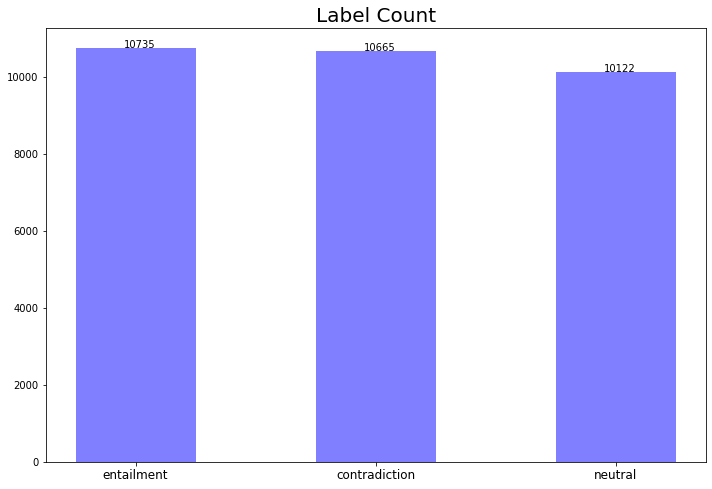

In [19]:
feature = train['label']

plt.figure(figsize=(10,7.5))
plt.title('Label Count', fontsize=20)

temp = feature.value_counts()
plt.bar(temp.keys(), temp.values, width=0.5, color='b', alpha=0.5)
plt.text(-0.05, temp.values[0]+20, s=temp.values[0])
plt.text(0.95, temp.values[1]+20, s=temp.values[1])
plt.text(1.95, temp.values[2]+20, s=temp.values[2])

plt.xticks(temp.keys(), fontsize=12) # x축 값, 폰트 크기 설정
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 레이아웃 설정
plt.show() # 그래프 나타내기

### 전제, 가설 길이 확인
Train에 존재하는 Premise(전제), Hypothesis(가설)의 길이를 확인하고 이를 통해 Tokenizer의 max_length 설정이 가능

In [20]:
train[train['premise'].map(len) > 1000]

,index,premise,hypothesis,label
6308,6308,이런 설명이 없다면 성이 프랑스식 수르놈에서 나온 정보라는 건 별로 관심이 없는 것...,Alice는 그 모든 것에 동의했다.,contradiction


In [21]:
train = train[train['index'] != 6308]

In [22]:
max_len = np.max(train['premise'].str.len())
min_len = np.min(train['premise'].str.len())
mean_len = np.mean(train['premise'].str.len())

print('Max Premise Length: ', max_len)
print('Min Premise Length: ', min_len)
print('Mean Premise Lenght: ', mean_len, '\n')

max_len = np.max(train['hypothesis'].str.len())
min_len = np.min(train['hypothesis'].str.len())
mean_len = np.mean(train['hypothesis'].str.len())

print('Max Hypothesis Length: ', max_len)
print('Min Hypothesis Length: ', min_len)
print('Mean Hypothesis Lenght: ', mean_len)

Max Premise Length:  146
Min Premise Length:  6
Mean Premise Lenght:  46.900222081218274 

Max Hypothesis Length:  104
Min Hypothesis Length:  3
Mean Hypothesis Lenght:  25.319479695431472


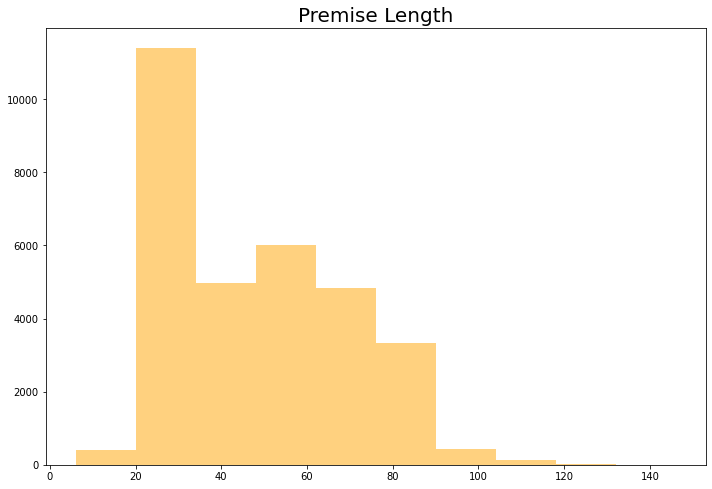

In [23]:
from collections import Counter

plt.figure(figsize=(10,7.5))
plt.title('Premise Length', fontsize=20)

plt.hist(train['premise'].str.len(), alpha=0.5, color='orange')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 레이아웃 설정

plt.show()

### 간단한 Test Preprocessing
전제, 가설에 존재하는 한글 단어가 아닌 다른 단어들은 전부 제거해줍니다.

In [24]:
train['premise'] = train['premise'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]', '')
test['premise'] = test['premise'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]", "")
train.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,index,premise,hypothesis,label
0,0,씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서 소년이나 장정들이 ...,씨름의 여자들의 놀이이다.,contradiction
1,1,삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나 ...,자작극을 벌인 이는 3명이다.,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
4,4,진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면 이런 상황에서는 ...,이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral


In [25]:
train['hypothesis'] = train['hypothesis'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]', '')
test['hypothesis'] = test['hypothesis'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]", "")
train.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,index,premise,hypothesis,label
0,0,씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서 소년이나 장정들이 ...,씨름의 여자들의 놀이이다,contradiction
1,1,삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나 ...,자작극을 벌인 이는 3명이다,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다,neutral
4,4,진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면 이런 상황에서는 ...,이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다,neutral


## Modeling

### Download transformers and Import Package

In [26]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 2.7 MB/s 
     |████████████████████████████████| 596 kB 49.9 MB/s 
     |████████████████████████████████| 895 kB 46.2 MB/s 
     |████████████████████████████████| 67 kB 4.9 MB/s 
     |████████████████████████████████| 6.8 MB 38.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import os
import random
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification, AutoConfig, AutoTokenizer

### Seed 고정, GPU 설정

In [ ]:
def seed_everything(seed:int = 1004):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(42)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

### Load Tokenizer, Model
Hugging Face Hub에 존재하는 Pretrained Tokenizer와 Model 및 Model Config를 불러옵니다.

이 때, Classification은 num_labels가 2로 Default되어있기 때문에 Model Config의 Parameter를 변경해줍니다.

In [ ]:
MODEL_NAME = 'klue/roberta-large'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

config = AutoConfig.from_pretrained(MODEL_NAME)
config.num_labels = 3

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)

print(model)
print(config)

### Tokenizing
Train Data를 Train과 Validation Dataset으로 나누고 각각 데이터를 Tokenizer를 통해 Tokenizing을 합니다.

Tokenizer에 들어가는 문장은 전제와 가설을 Concat한 문장이 됩니다.

In [ ]:
train_dataset, eval_dataset = train_test_split(train, test_size=0.2, shuffle=False, stratify=train['label'])

tokenized_train = tokenizer(
    list(train_dataset['premise']),
    list(train_dataset['hypothesis']),
    return_tensors="pt",
    max_length=128, # Max_Length = 190
    padding=True,
    truncation=True,
    add_special_tokens=True
)

tokenized_eval = tokenizer(
    list(eval_dataset['premise']),
    list(eval_dataset['hypothesis']),
    return_tensors="pt",
    max_length=128,
    padding=True,
    truncation=True,
    add_special_tokens=True
)

print(tokenized_train['input_ids'][0])
print(tokenizer.decode(tokenized_train['input_ids'][0]))

In [ ]:
train_dataset

In [ ]:
class BERTDataset(torch.utils.data.Dataset):
    def __init__(self, pair_dataset, label):
        self.pair_dataset = pair_dataset
        self.label = label

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.pair_dataset.items()}
        item['label'] = torch.tensor(self.label[idx])
        
        return item

    def __len__(self):
        return len(self.label)

In [ ]:
def label_to_num(label):
    label_dict = {"entailment": 0, "contradiction": 1, "neutral": 2, "answer": 3}
    num_label = []

    for v in label:
        num_label.append(label_dict[v])
    
    return num_label


train_label = label_to_num(train_dataset['label'].values)
eval_label = label_to_num(eval_dataset['label'].values)

In [ ]:
train_dataset = BERTDataset(tokenized_train, train_label)
eval_dataset = BERTDataset(tokenized_eval, eval_label)

print(train_dataset.__len__())
print(train_dataset.__getitem__(5218))
print(tokenizer.decode(train_dataset.__getitem__(5218)['input_ids']))

In [ ]:
def compute_metrics(pred):
  """ validation을 위한 metrics function """
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  probs = pred.predictions

  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds) # 리더보드 평가에는 포함되지 않습니다.

  return {
      'accuracy': acc,
  }

In [ ]:
training_ars = TrainingArguments(
    output_dir='./result',
    num_train_epochs=10,
    per_device_train_batch_size=32,
    save_total_limit=5,
    save_steps=500,
    evaluation_strategy='steps',
    eval_steps = 500,
    load_best_model_at_end = True,
)

trainer = Trainer(
    model=model,
    args=training_ars,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()
model.save_pretrained('./result/best_model')

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Tokenizer_NAME = "klue/roberta-large"
tokenizer = AutoTokenizer.from_pretrained(Tokenizer_NAME)

MODEL_NAME = './result/checkpoint-5000'
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.resize_token_embeddings(tokenizer.vocab_size)
model.to(device)

print(tokenizer)

In [ ]:
test_label = label_to_num(test['label'].values)

tokenized_test = tokenizer(
    list(test['premise']),
    list(test['hypothesis']),
    return_tensors="pt",
    max_length=128,
    padding=True,
    truncation=True,
    add_special_tokens=True
)

test_dataset = BERTDataset(tokenized_test, test_label)

print(test_dataset.__len__())
print(test_dataset.__getitem__(1665))
print(tokenizer.decode(test_dataset.__getitem__(6)['input_ids']))

In [ ]:
dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
output_pred = []
output_prob = []

for i, data in enumerate(tqdm(dataloader)):
    with torch.no_grad():
        outputs = model(
            input_ids=data['input_ids'].to(device),
            attention_mask=data['attention_mask'].to(device),
            token_type_ids=data['token_type_ids'].to(device)
        )
    logits = outputs[0]
    prob = F.softmax(logits, dim=-1).detach().cpu().numpy()
    logits = logits.detach().cpu().numpy()
    result = np.argmax(logits, axis=-1)

    output_pred.append(result)
    output_prob.append(prob)
  
pred_answer, output_prob = np.concatenate(output_pred).tolist(), np.concatenate(output_prob, axis=0).tolist()
print(pred_answer)

In [ ]:
def num_to_label(label):
    label_dict = {0: "entailment", 1: "contradiction", 2: "neutral"}
    str_label = []

    for i, v in enumerate(label):
        str_label.append([i,label_dict[v]])
    
    return str_label

answer = num_to_label(pred_answer)
print(answer)

In [ ]:
df = pd.DataFrame(answer, columns=['index', 'label'])

df.to_csv('./result/submission.csv', index=False)

print(df)